In [1]:
%pip install tensorflow[and-cuda] scikit-learn matplotlib seaborn pandas imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


Proyecto Aprendizaje Automático: Predicción del Alzheimer

Santiago Valdez Bocardo

Sebastián Arturo Jácome Herrera

Este código realiza un análisis y modelado predictivo del diagnóstico de Alzheimer utilizando Machine Learning y Deep Learning.

Pasos principales:
1. **Carga y exploración de datos**: Se analiza la estructura del dataset.
2. **Preprocesamiento**: Se eliminan columnas redundantes, se codifican variables categóricas y se escalan datos numéricos.
3. **Balanceo de clases**: Se aplican técnicas de Near Miss y SMOTE para abordar el desbalance en los datos.
4. **Entrenamiento de modelos**: Se prueban modelos de Decision Tree, Logistic Regression, SVM y Neural Network.
5. **Reducción de dimensionalidad**: Se aplica PCA para mejorar el desempeño de los modelos.
6. **Optimización del mejor modelo**: Se usa GridSearch para ajustar hiperparámetros en la red neuronal.
7. **Evaluación y visualización de resultados**: Se calculan métricas como Accuracy, Precision, Recall y F1-Score y se generan visualizaciones de los modelos.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn import tree
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import itertools

2025-03-06 08:55:26.780918: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 08:55:26.788983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741272926.798241 2010287 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741272926.800961 2010287 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 08:55:26.810513: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
import warnings

warnings.filterwarnings('ignore')

Primeras filas

Mostrar las primeras filas del dataset para tener una idea general de su contenido

In [4]:
file_path = "./alzheimers_prediction_dataset.csv"
df = pd.read_csv(file_path)
df.head(5)

,Country,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,...,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
0,Spain,90,Male,1,33.0,Medium,Never,Occasionally,No,No,...,Healthy,High,Retired,Single,No,Low,Medium,High,Urban,No
1,Argentina,72,Male,7,29.9,Medium,Former,Never,No,No,...,Healthy,Medium,Unemployed,Widowed,No,High,Low,High,Urban,No
2,South Africa,86,Female,19,22.9,High,Current,Occasionally,No,Yes,...,Average,Medium,Employed,Single,No,Low,Medium,High,Rural,No
3,China,53,Male,17,31.2,Low,Never,Regularly,Yes,No,...,Healthy,Medium,Retired,Single,No,High,Medium,Low,Rural,No
4,Sweden,58,Female,3,30.0,High,Former,Never,Yes,No,...,Unhealthy,High,Employed,Married,No,Low,Medium,High,Rural,No


# Conjunto de datos

Alzheimer’s Prediction Dataset (Global) es un conjunto de datos que contiene 74,283 registros provenientes de 20 países distintos. Este conjunto de datos es útil para modelos predictivos, estudios epidemiológicos e investigaciones sanitarias sobre la enfermedad de Alzheimer.



Atributos del Dataset


* Datos Demográficos:

Country: País de origen del individuo.

Age: Edad del individuo.

Gender: Género (Male/Female).

Education Level: Nivel educativo alcanzado (expresado en años de educación).

* Factores de Estilo de Vida:

Physical Activity Level: Nivel de actividad física (Bajo, Medio, Alto).

Smoking Status: Estado de tabaquismo (Nunca, Exfumador, Actual).

Alcohol Consumption: Frecuencia de consumo de alcohol (Nunca, Ocasionalmente, Regularmente).

Dietary Habits: Tipo de alimentación (Saludable, Promedio).

Air Pollution Exposure: Nivel de exposición a la contaminación del aire (Bajo, Medio, Alto).

Social Engagement Level: Nivel de participación en actividades sociales (Bajo, Medio, Alto).

Urban vs Rural Living: Lugar de residencia (Urbano/Rural).

* Factores Médicos:

BMI: Índice de Masa Corporal (IMC).

Diabetes: Presencia de diabetes (Sí/No).

Hypertension: Hipertensión arterial (Sí/No).

Cholesterol Level: Nivel de colesterol (Normal/Alto).

Family History of Alzheimer’s: Antecedentes familiares de Alzheimer (Sí/No).

Cognitive Test Score: Puntuación en pruebas cognitivas.

Depression Level: Nivel de depresión (Bajo, Medio, Alto).

Sleep Quality: Calidad del sueño (Buena, Regular, Pobre).


Stress Levels: Niveles de estrés (Bajo, Medio, Alto).

* Factores Genéticos y Económicos:

Genetic Risk Factor (APOE-ε4 allele): Presencia del alelo APOE-ε4 (Sí/No).

Income Level: Nivel de ingresos (Bajo, Medio, Alto).

Employment Status: Estado laboral (Empleado, Desempleado, Jubilado).

Marital Status: Estado civil (Soltero, Casado, Viudo).

* Variable Objetivo:

Alzheimer’s Diagnosis: Diagnóstico de Alzheimer, variable binaria con los valores:

0 (No): No se ha diagnosticado Alzheimer.

1 (Sí): Diagnóstico positivo de Alzheimer.




# Exploración de datos

Información General del Dataset

Análisis de la estructura general del dataset, incluyendo el número de columnas y tipos de datos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  object 
 1   Age                                   74283 non-null  int64  
 2   Gender                                74283 non-null  object 
 3   Education Level                       74283 non-null  int64  
 4   BMI                                   74283 non-null  float64
 5   Physical Activity Level               74283 non-null  object 
 6   Smoking Status                        74283 non-null  object 
 7   Alcohol Consumption                   74283 non-null  object 
 8   Diabetes                              74283 non-null  object 
 9   Hypertension                          74283 non-null  object 
 10  Cholesterol Level                     74283 non-null  object 
 11  Family History 

In [6]:
df.shape

(74283, 25)

Valores Faltantes

In [7]:
df.isnull().sum()

Country                                 0
Age                                     0
Gender                                  0
Education Level                         0
BMI                                     0
Physical Activity Level                 0
Smoking Status                          0
Alcohol Consumption                     0
Diabetes                                0
Hypertension                            0
Cholesterol Level                       0
Family History of Alzheimer’s           0
Cognitive Test Score                    0
Depression Level                        0
Sleep Quality                           0
Dietary Habits                          0
Air Pollution Exposure                  0
Employment Status                       0
Marital Status                          0
Genetic Risk Factor (APOE-ε4 allele)    0
Social Engagement Level                 0
Income Level                            0
Stress Levels                           0
Urban vs Rural Living             

Datos Duplicados

In [8]:
duplicated = df[df.duplicated()]
duplicated

,Country,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,...,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis


In [9]:
df.columns

Index(['Country', 'Age', 'Gender', 'Education Level', 'BMI',
       'Physical Activity Level', 'Smoking Status', 'Alcohol Consumption',
       'Diabetes', 'Hypertension', 'Cholesterol Level',
       'Family History of Alzheimer’s', 'Cognitive Test Score',
       'Depression Level', 'Sleep Quality', 'Dietary Habits',
       'Air Pollution Exposure', 'Employment Status', 'Marital Status',
       'Genetic Risk Factor (APOE-ε4 allele)', 'Social Engagement Level',
       'Income Level', 'Stress Levels', 'Urban vs Rural Living',
       'Alzheimer’s Diagnosis'],
      dtype='object')

In [10]:
for i in range(len(df.columns)):
    ben = df.groupby(df.columns[i]).count()
    print("Column: ", ben.iloc[:, 0])
    print('\n')

Column:  Country
Argentina       3731
Australia       3787
Brazil          3839
Canada          3711
China           3592
France          3710
Germany         3807
India           3741
Italy           3724
Japan           3751
Mexico          3598
Norway          3706
Russia          3778
Saudi Arabia    3662
South Africa    3760
South Korea     3732
Spain           3698
Sweden          3689
UK              3651
USA             3616
Name: Age, dtype: int64


Column:  Age
50    1701
51    1672
52    1616
53    1625
54    1681
55    1614
56    1615
57    1655
58    1612
59    1655
60    1703
61    1684
62    1677
63    1641
64    1709
65    1684
66    1659
67    1655
68    1576
69    1684
70    1611
71    1682
72    1731
73    1596
74    1624
75    1671
76    1690
77    1577
78    1632
79    1641
80    1673
81    1670
82    1712
83    1629
84    1595
85    1602
86    1668
87    1644
88    1653
89    1656
90    1665
91    1622
92    1607
93    1649
94    1665
Name: Country, dtype: int64



There are 2 types of possible results:
* Yes with 30713 rows
* No with 43570 rows


Estadísticas generales

Visualización de estadísticas descriptivas para evaluar la distribución de las variables numéricas

In [11]:
df.describe()

,Age,Education Level,BMI,Cognitive Test Score
count,74283.000000,74283.000000,74283.000000,74283.000000
mean,71.964703,9.487514,26.780639,64.654241
std,12.980748,5.757020,4.764679,20.153247
min,50.000000,0.000000,18.500000,30.000000
25%,61.000000,4.000000,22.700000,47.000000
50%,72.000000,9.000000,26.800000,65.000000
75%,83.000000,14.000000,30.900000,82.000000
max,94.000000,19.000000,35.000000,99.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  object 
 1   Age                                   74283 non-null  int64  
 2   Gender                                74283 non-null  object 
 3   Education Level                       74283 non-null  int64  
 4   BMI                                   74283 non-null  float64
 5   Physical Activity Level               74283 non-null  object 
 6   Smoking Status                        74283 non-null  object 
 7   Alcohol Consumption                   74283 non-null  object 
 8   Diabetes                              74283 non-null  object 
 9   Hypertension                          74283 non-null  object 
 10  Cholesterol Level                     74283 non-null  object 
 11  Family History 

Distribución de variable objetivo

Esto ayuda a identificar si la variable objetivo está balanceada o no

In [13]:
print(df.columns.tolist())

['Country', 'Age', 'Gender', 'Education Level', 'BMI', 'Physical Activity Level', 'Smoking Status', 'Alcohol Consumption', 'Diabetes', 'Hypertension', 'Cholesterol Level', 'Family History of Alzheimer’s', 'Cognitive Test Score', 'Depression Level', 'Sleep Quality', 'Dietary Habits', 'Air Pollution Exposure', 'Employment Status', 'Marital Status', 'Genetic Risk Factor (APOE-ε4 allele)', 'Social Engagement Level', 'Income Level', 'Stress Levels', 'Urban vs Rural Living', 'Alzheimer’s Diagnosis']


– ¿Cuántos datos tienes, cuántas filas, cuántas columnas?

Hay 1857075 datos, 74,283 filas y 25 columnas.

– ¿Hay datos faltantes?

El dataset no muestra datos faltantes

– ¿Hay contenido redundante o duplicado?

No se encuentran datos repetidos en el dataset, sin embargo algunas posibles columnas redundantes son:

* Country: No aporta información para la predicción individual.
* Cognitive Test Score: Correlacionada con la variable objetivo.
* Employment Status, Marital Status, Income Level, Urban vs Rural Living:
 Podrían estar cubiertas por otras variables como Social Engagement Level o Education Level.

– ¿Cuál es la distribución de los datos en la clase objetivo?

Alzheimer’s Diagnosis (Variable Objetivo):
* No (sin Alzheimer): 58.65%
* Sí (con Alzheimer): 41.35%

La distribución no está completamente balanceada, pero no es un caso extremo de desbalanceo, así que se puede dejar como está

– ¿Existen correlaciones entre las categorías?

De acuerdo con la matriz, no hay correlaciones significativas entre las variables numéricas

Age, Education Level, BMI, y Cognitive Test Score tienen valores de correlación cercanos a 0 entre sí, indicando que no hay relaciones lineales fuertes entre estas variables.


Dado que no hay una relación fuerte entre las variables numéricas, no parece haber redundancia dentro de ellas.

In [14]:
df.drop(columns=[
    "Country",
    "Cognitive Test Score",
    "Employment Status",
    "Marital Status",
    "Income Level",
    "Urban vs Rural Living"
], inplace=True)


df_processed = df

label_cols = [
    "Smoking Status", "Alcohol Consumption", "Dietary Habits"
]

label_encoder = LabelEncoder()
for col in label_cols:
    df_processed[col] = label_encoder.fit_transform(df[col])

one_hot_cols = [
    "Gender", "Diabetes", "Hypertension", "Genetic Risk Factor (APOE-ε4 allele)", 
    "Alzheimer’s Diagnosis", "Family History of Alzheimer’s"
]

df_processed = pd.get_dummies(df_processed, columns = one_hot_cols, drop_first=True)

ordinal_cols = [
    "Physical Activity Level", "Cholesterol Level", "Depression Level", "Sleep Quality", 
    "Air Pollution Exposure", "Social Engagement Level", "Stress Levels"
]

ordinal_mappings = { 
    "Physical Activity Level": ["Low", "Medium", "High"],
    "Cholesterol Level": ["Normal", "High"],
    "Depression Level": ["Low", "Medium", "High",],
    "Sleep Quality": ["Poor", "Average", "Good"],
    "Air Pollution Exposure": ["Low", "Medium", "High"],
    "Social Engagement Level": ["Low", "Medium", "High"],
    "Stress Levels": ["Low", "Medium", "High"]
}

ordinal_encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_cols])
df_processed[ordinal_cols] = ordinal_encoder.fit_transform(df_processed[ordinal_cols])

In [15]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 19 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Age                                       74283 non-null  int64  
 1   Education Level                           74283 non-null  int64  
 2   BMI                                       74283 non-null  float64
 3   Physical Activity Level                   74283 non-null  float64
 4   Smoking Status                            74283 non-null  int64  
 5   Alcohol Consumption                       74283 non-null  int64  
 6   Cholesterol Level                         74283 non-null  float64
 7   Depression Level                          74283 non-null  float64
 8   Sleep Quality                             74283 non-null  float64
 9   Dietary Habits                            74283 non-null  int64  
 10  Air Pollution Exposure            

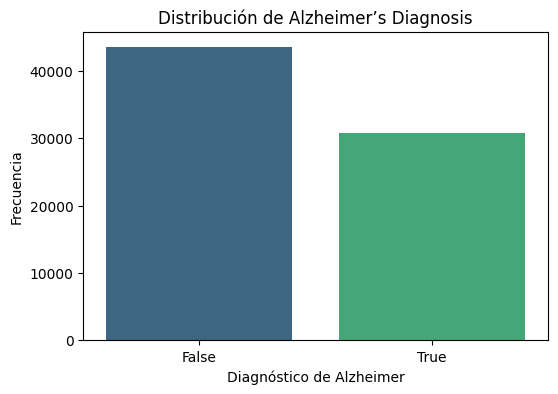

In [16]:
target_column = df_processed['Alzheimer’s Diagnosis_Yes']

plt.figure(figsize=(6, 4))
sns.countplot(x=target_column, data=df_processed, palette="viridis")
plt.title("Distribución de Alzheimer’s Diagnosis")
plt.xlabel("Diagnóstico de Alzheimer")
plt.ylabel("Frecuencia")
plt.show()

Matriz de Correlación

Se genera la matriz para analizar las correlaciones entre variables numéricas y detectar posibles relaciones

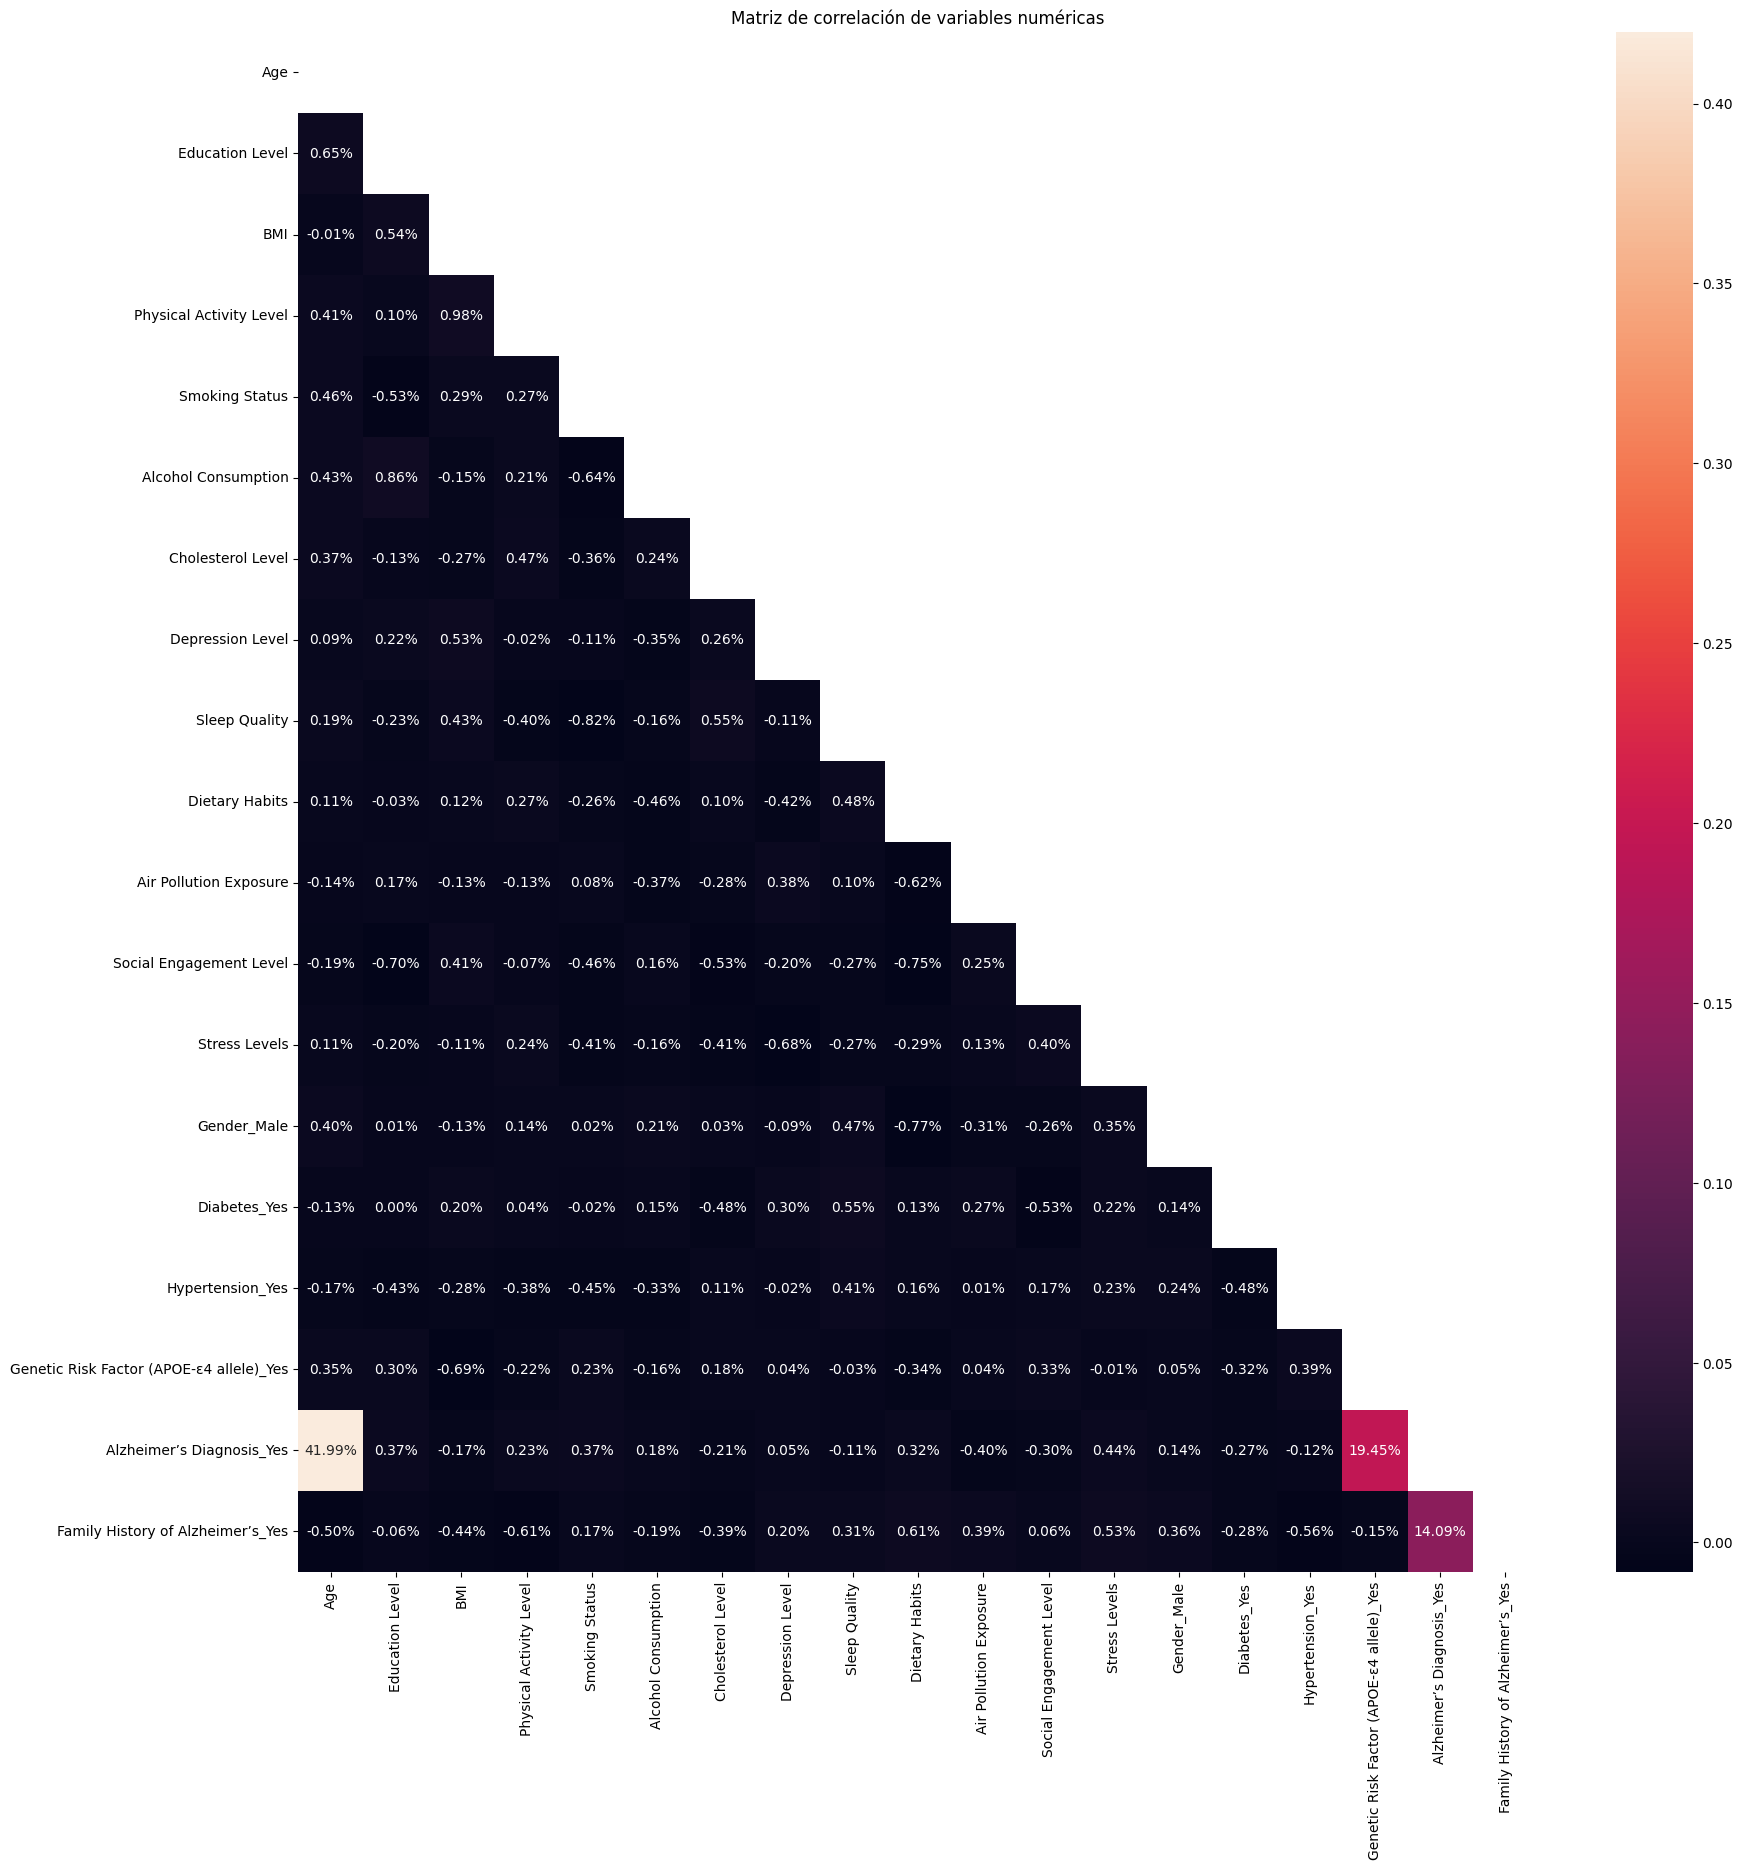

In [17]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_processed.corr(), annot=True, fmt=".2%", mask=np.triu(np.ones_like(df_processed.corr())))
plt.title("Matriz de correlación de variables numéricas")
plt.show()

Separación de datos

Se separan los datos en entrenamiento y prueba en una proporción 80%-20%

In [18]:
X = df_processed.drop(columns=["Alzheimer’s Diagnosis_Yes"])
y = df_processed["Alzheimer’s Diagnosis_Yes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Escalado de variables numericas

Se normalizan variables numéricas usando StandardScaler o MinMaxScaler para mejorar el desempeño de los modelos

In [19]:
numerical_columns = ["Age", "Education Level", "BMI"]
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [20]:
print("\n--- Información después del preprocesamiento ---")
print(X_train.info())
print("\n--- Primeras Filas del Dataset Preprocesado ---")
print(X_train.head())


--- Información después del preprocesamiento ---
<class 'pandas.core.frame.DataFrame'>
Index: 59426 entries, 14565 to 15795
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Age                                       59426 non-null  float64
 1   Education Level                           59426 non-null  float64
 2   BMI                                       59426 non-null  float64
 3   Physical Activity Level                   59426 non-null  float64
 4   Smoking Status                            59426 non-null  int64  
 5   Alcohol Consumption                       59426 non-null  int64  
 6   Cholesterol Level                         59426 non-null  float64
 7   Depression Level                          59426 non-null  float64
 8   Sleep Quality                             59426 non-null  float64
 9   Dietary Habits                            59426 non-null

# Procesamiento

Aplicación de técnicas de balanceo

Random Over Sampling
Duplica algunos ejemplos de nuestra clase minoritaria para estar a la par de la mayoritaria

Random Under Sampling
Elimina ejemplos de la clase mayoritaria para estar a la par de la minoritaria

Near-miss
Reduce la cantidad de muestras de la clase mayoritaria

In [21]:
# undersampling
nearmiss = NearMiss()
X_train_nm, y_train_nm = nearmiss.fit_resample(X_train, y_train)

SMOTE

Genera nuevas muestras sintéticas para la clase minoritaria

In [22]:
# oversampling
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Definición y entrenamiento de modelos

Se entrena y evalúa cada modelo con los datasets original, Near Miss y SMOTE

In [23]:
models = {
    "Decision Tree": tree.DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC()
}

In [24]:
results = []
for model_name, model in models.items():
    for dataset_name, X_tr, y_tr in zip(["Original", "Near Miss", "SMOTE"],
                                        [X_train, X_train_nm, X_train_sm],
                                        [y_train, y_train_nm, y_train_sm]):
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append([model_name, dataset_name, accuracy])

Red neuronal

Se implementa una red neuronal con capas densas y dropout para evitar sobreajuste

In [25]:
def train_neural_network(X_train, y_train, X_test, y_test, dataset_name):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2, verbose=0)

    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    results.append(["Neural Network", dataset_name, accuracy])

In [26]:
train_neural_network(X_train, y_train, X_test, y_test, "Original")
train_neural_network(X_train_nm, y_train_nm, X_test, y_test, "Near Miss")
train_neural_network(X_train_sm, y_train_sm, X_test, y_test, "SMOTE")

I0000 00:00:1741273109.749133 2010287 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22265 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1741273110.693650 2010817 service.cc:148] XLA service 0x7ed380006870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741273110.693671 2010817 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-06 08:58:30.706685: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741273110.777896 2010817 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1741273111.220765 2010817 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [27]:
results_df = pd.DataFrame(results, columns=["Modelo", "Dataset", "Accuracy"])
print(results_df)

                 Modelo    Dataset  Accuracy
0         Decision Tree   Original  0.630477
1         Decision Tree  Near Miss  0.604967
2         Decision Tree      SMOTE  0.628795
3   Logistic Regression   Original  0.711584
4   Logistic Regression  Near Miss  0.697853
5   Logistic Regression      SMOTE  0.711988
6                   SVM   Original  0.717440
7                   SVM  Near Miss  0.698862
8                   SVM      SMOTE  0.715891
9        Neural Network   Original  0.715016
10       Neural Network  Near Miss  0.687016
11       Neural Network      SMOTE  0.717843


# Logistic Regression

In [28]:
# Random Under Sampling
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)
print(len(X_under), len(y_under))
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)
model = LogisticRegression(class_weight='balanced' , max_iter=1000 , random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)
results.append(["Logistic Regression", 'Random Under Sampling', model.score(X_test, y_test)])

61426 61426


In [29]:
# Random Over Sampling
oversampler = RandomOverSampler(random_state=42)
X_over, y_over = oversampler.fit_resample(X, y)
print(len(X_over), len(y_over))
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)
model = LogisticRegression(class_weight='balanced' , max_iter=1000 , random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)
results.append(["Logistic Regression", 'Random Over Sampling', model.score(X_test, y_test)])

87140 87140


# Decision Tree

In [30]:
# Random Under Sampling
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)
print(len(X_under), len(y_under))
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)
dt_under = tree.DecisionTreeClassifier()
dt_under = dt_under.fit(X_train, y_train)
dt_under.score(X_test, y_test)
results.append(["Decision Tree", 'Random Under Sampling', dt_under.score(X_test, y_test)])

61426 61426


In [31]:
# Random Over Sampling
oversampler = RandomOverSampler(random_state=42)
X_over, y_over = oversampler.fit_resample(X, y)
print(len(X_over), len(y_over))
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)
dt_over = tree.DecisionTreeClassifier()
dt_over = dt_over.fit(X_train, y_train)
dt_over.score(X_test, y_test)
results.append(["Decision Tree", 'Random Over Sampling', dt_over.score(X_test, y_test)])

87140 87140


# Redes Neuronales

Aquí continuación se usa el escalador MinMaxScaler, que en general nos dio mejores resultados. También, por alguna razón, nos dio algunos errores el intentar hacerlo con StandardScaler al principio.

In [32]:
# MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_processed)
df_scaled = pd.DataFrame(scaled_data, columns=df_processed.columns)


In [34]:
# Under Sampler
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)
model = keras.Sequential([])
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=16, epochs=10)
res_nn = model.evaluate(X_test, y_test)
print(res_nn)
train_accuracy = history.history['accuracy'][-1]
results.append(["Neural Network", 'Random Under Sampling', train_accuracy])

Epoch 1/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 3s 832us/step - accuracy: 0.6693 - loss: 0.6021
Epoch 2/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 2s 656us/step - accuracy: 0.7170 - loss: 0.5599
Epoch 3/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 2s 675us/step - accuracy: 0.7168 - loss: 0.5584
Epoch 4/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 2s 664us/step - accuracy: 0.7204 - loss: 0.5529
Epoch 5/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 2s 670us/step - accuracy: 0.7245 - loss: 0.5504
Epoch 6/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 2s 641us/step - accuracy: 0.7217 - loss: 0.5526
Epoch 7/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 2s 656us/step - accuracy: 0.7206 - loss: 0.5525
Epoch 8/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 2s 666us/step - accuracy: 0.7208 - loss: 0.5534
Epoch 9/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 2s 684us/step - accuracy: 0.7238 - loss: 0.5478
Epoch 10/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 2s 681us/step - accuracy: 0.7270 - loss: 0.5459


In [35]:
# Over Sampler
oversampler = RandomOverSampler(random_state=42)
X_over, y_over = oversampler.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)
model = keras.Sequential([])
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=16, epochs=10)
res_nn = model.evaluate(X_test, y_test)
print(res_nn)
train_accuracy = history.history['accuracy'][-1]
results.append(["Neural Network", 'Random Over Sampling', train_accuracy])

Epoch 1/10
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 4s 658us/step - accuracy: 0.6690 - loss: 0.6023
Epoch 2/10
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 3s 690us/step - accuracy: 0.7130 - loss: 0.5631
Epoch 3/10
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 3s 640us/step - accuracy: 0.7155 - loss: 0.5593
Epoch 4/10
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 3s 633us/step - accuracy: 0.7191 - loss: 0.5569
Epoch 5/10
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 3s 668us/step - accuracy: 0.7208 - loss: 0.5542
Epoch 6/10
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 3s 650us/step - accuracy: 0.7236 - loss: 0.5517
Epoch 7/10
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 3s 683us/step - accuracy: 0.7210 - loss: 0.5530
Epoch 8/10
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 3s 665us/step - accuracy: 0.7239 - loss: 0.5488
Epoch 9/10
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 3s 666us/step - accuracy: 0.7226 - loss: 0.5500
Epoch 10/10
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 3s 680us/step - accuracy: 0.7270 - loss: 0.5450


# SVM

In [37]:
# Random Under Sampling
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)
svm_under = SVC(kernel='rbf')
svm_under.fit(X_train, y_train)
svm_under.score(X_test, y_test)
results.append(["SVM", 'Random Under Sampling', svm_under.score(X_test, y_test)])

In [38]:
# Random Over Sampling
oversampler = RandomOverSampler(random_state=42)
X_over, y_over = oversampler.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)
svm_over = SVC(kernel='rbf')
svm_over.fit(X_train, y_train)
svm_over.score(X_test, y_test)
results.append(["SVM", 'Random Over Sampling', svm.score(X_test, y_test)])

In [39]:
sorted_results = sorted(results, key=lambda x: x[2], reverse=True)
results_df = pd.DataFrame(sorted_results, columns=["Modelo", "Algoritmo", "Accuracy"])
print(results_df)

                 Modelo              Algoritmo  Accuracy
0        Neural Network   Random Over Sampling  0.723893
1        Neural Network  Random Under Sampling  0.723769
2         Decision Tree   Random Over Sampling  0.721081
3        Neural Network               Original  0.719618
4        Neural Network                  SMOTE  0.717843
5                   SVM               Original  0.717440
6                   SVM                  SMOTE  0.715891
7        Neural Network               Original  0.715016
8   Logistic Regression   Random Over Sampling  0.714368
9                   SVM  Random Under Sampling  0.714146
10  Logistic Regression                  SMOTE  0.711988
11  Logistic Regression               Original  0.711584
12                  SVM   Random Over Sampling  0.708228
13  Logistic Regression  Random Under Sampling  0.707065
14                  SVM               Original  0.705930
15                  SVM              Near Miss  0.698862
16  Logistic Regression        

Es importante denotar que puede que, debido a la cercanía entre precisiones, varíen los 3 mejores resultados.
En nuestra última ejecución, se pudo observar que los mejores resultados fueron:

Neural Network Over Sampling -> 0.7238
Neural Network Under Sampling -> 0.7237
Decision Tree Over Sampling -> 0.7168

Se usarán estos modelos para PCA

# PCA
Se usa PCA para reducir la dimensionalidad (cantidad de variables) y eliminar ruido en los datos

In [40]:
X = df_scaled.drop("Alzheimer’s Diagnosis_Yes", axis=1)
y = df_scaled['Alzheimer’s Diagnosis_Yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
reduced_exp_variance = list()

total=0
for n in range(len(explained_variance)):
    total += explained_variance[n]
    reduced_exp_variance.append(explained_variance[n])
    if(total>0.9):
        break
print("Número de componentes que forman el 90%: ", n)
print(reduced_exp_variance)


Número de componentes que forman el 90%:  14
[np.float64(0.08450244021124571), np.float64(0.0714612621756472), np.float64(0.07098940474898259), np.float64(0.07039726356339245), np.float64(0.05740486798484598), np.float64(0.05696745633219404), np.float64(0.05677504956967029), np.float64(0.05655569863316771), np.float64(0.056250764379749456), np.float64(0.05603042353323885), np.float64(0.055852993834913246), np.float64(0.05558555228281508), np.float64(0.0554223810936733), np.float64(0.05368829594497714), np.float64(0.05340995705795337)]


Visualización de la varianza explicada por los componentes principales

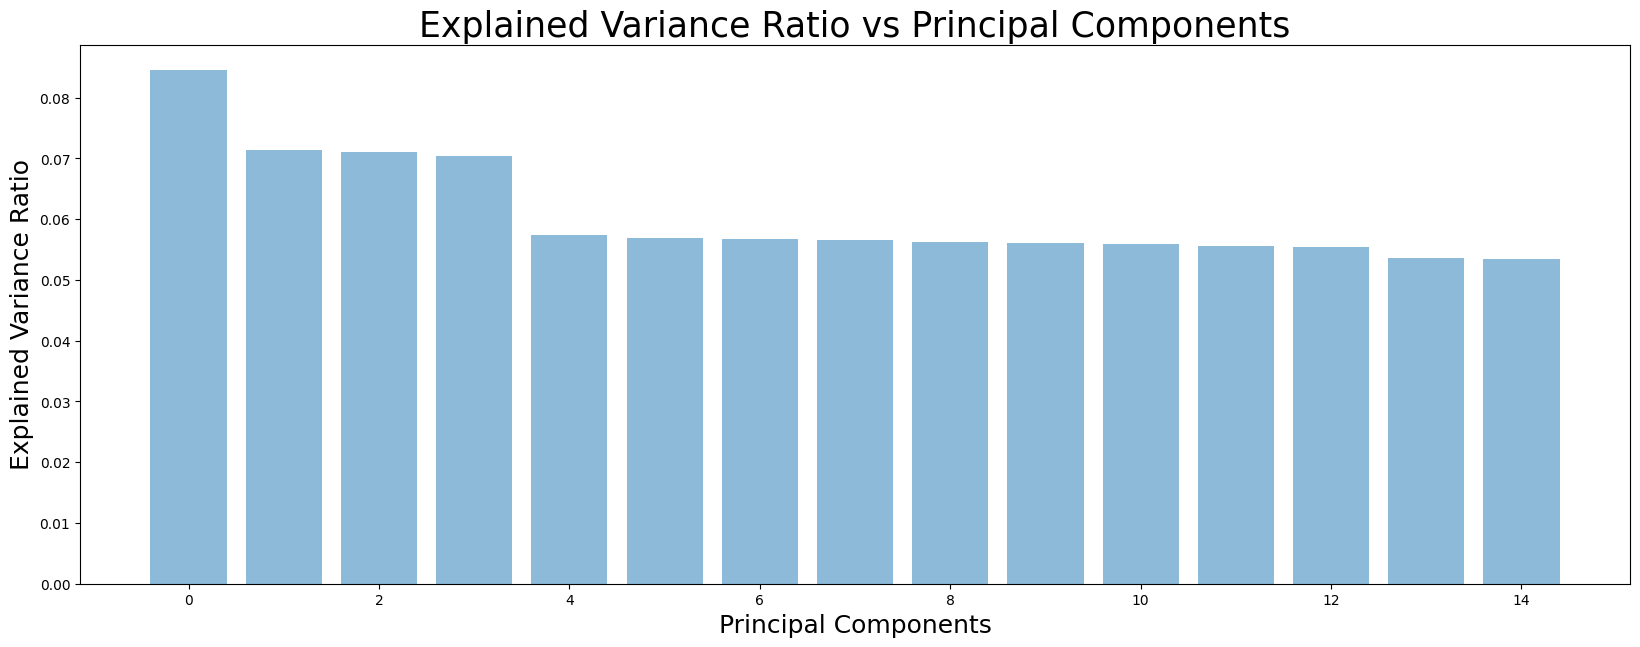

In [41]:
background_color = "#ffffff"
fig = plt.figure(figsize=(20,7), facecolor=background_color)
plt.bar(range(n+1), reduced_exp_variance, alpha=0.5, align='center', label='Individual Explained Variance')
plt.ylabel('Explained Variance Ratio',  fontsize = 18)
plt.xlabel('Principal Components', fontsize = 18)
plt.title('Explained Variance Ratio vs Principal Components', fontsize = 25)
plt.show()

Se muestra que el valor se encuentra en los primeros 14 componentes, ya que explican la mayor parte de la varianza; se utilizarán para la aplicación del PCA

In [ ]:
# Neural Network Random Over Sampler (1er Lugar)
oversampler = RandomOverSampler(random_state=42)
X_over, y_over = oversampler.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

pca = PCA(n_components=n)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

model = keras.Sequential([])
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=16, epochs=10)
res_nn = model.evaluate(X_test, y_test)
print(res_nn)
train_accuracy = history.history['accuracy'][-1]
print(train_accuracy)

In [1]:
# Neural Network Random Under Sampler (2do Lugar)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)

pca = PCA(n_components=n)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

model = keras.Sequential([])
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=16, epochs=10)
res_nn = model.evaluate(X_test, y_test)
print(res_nn)
train_accuracy = history.history['accuracy'][-1]
print(train_accuracy)

NameError: name 'RandomUnderSampler' is not defined

In [44]:
# Decision Tree Random Over Sampling (3er Lugar)
oversampler = RandomOverSampler(random_state=42)
X_over, y_over = oversampler.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

pca = PCA(n_components=n)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

dt_over = tree.DecisionTreeClassifier()
dt_over = dt_over.fit(X_train, y_train)
dt_over.score(X_test, y_test)

0.647521230204269

# Modelado

En nuestro caso, incluso después de realizar el PCA. Se obtuvieron mejores resultados con el Neural Network utilizando Random Over Sampling.
Por lo que se hará el GridSearch con este modelo

In [ ]:
# Neural Network Random Over Sampler (GridSearchCV)
oversampler = RandomOverSampler(random_state=42)
X_over, y_over = oversampler.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)
model = keras.Sequential([])
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

parameters = [{
    'batch_size': [16, 32],
    'epochs': [5, 10],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.01, 0.001],
    'neurons1': [64, 32],
    'neurons2': [32, 16],
    'neurons3': [16, 8],
    'activation': ['relu']
}]

keras_clf = KerasClassifier(build_fn=lambda: model, verbose=0)

grid_search = GridSearchCV(
    estimator=keras_clf,
    param_grid=parameters,
    scoring='accuracy',
    cv=5,
    verbose=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

# Mejor modelo del GridSearch

In [47]:
best_model = grid_search.best_estimator_
accuracy_best_model = grid_search.best_score_
y_pred = best_model.predict(X_test)

A continuación se grafica visualmente la matriz de confusión

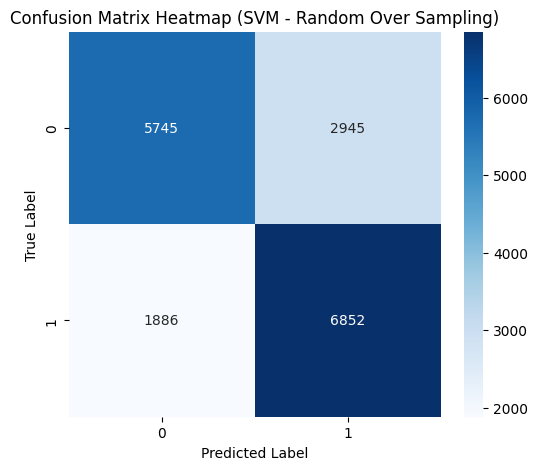

In [48]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap (SVM - Random Over Sampling)")
plt.show()

# Evaluación del modelo

Para no afectar valores que ya fueron ejecutados, para este paso se decidió entrenar los modelos nuevamente.

In [ ]:
# Neural Network Random Under Sampler (2do Lugar antes de GridSearch)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)
model = keras.Sequential([])
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=16, epochs=10)
res_nn = model.evaluate(X_test, y_test)
print(res_nn)
train_accuracy = history.history['accuracy'][-1]

# Resultados Del GridSearch 

A continuación, se mostrará una gráfica que compara el modelo SVM, tanto con GridSearch, como sin este.

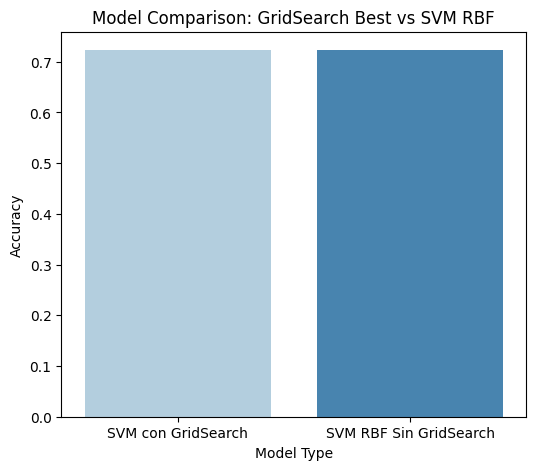

[CV 4/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.725 total time=10.4min
[CV 5/5] END ....C=10, gamma=scale, kernel=poly;, score=0.717 total time=30.2min
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.722 total time=10.3min
[CV 4/5] END ....C=10, gamma=scale, kernel=poly;, score=0.718 total time=30.7min
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.723 total time= 9.8min
[CV 3/5] END ....C=10, gamma=scale, kernel=poly;, score=0.715 total time=31.2min
[CV 5/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.721 total time= 9.6min
[CV 1/5] END ....C=10, gamma=scale, kernel=poly;, score=0.713 total time=31.5min
[CV 3/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.724 total time= 9.7min
[CV 2/5] END ....C=10, gamma=scale, kernel=poly;, score=0.715 total time=31.4min


In [50]:
results = [
    ["Neural Network Random Over Sampling con GridSearch", accuracy_best_model],
    ["Neural Network Random Under Sampling Sin GridSearch", train_accuracy]
]
df_results = pd.DataFrame(results, columns=["Model", "Accuracy"])

plt.figure(figsize=(6, 5))
sns.barplot(data=df_results, x="Model", y="Accuracy", palette="Blues")
plt.xlabel("Model Type")
plt.ylabel("Accuracy")
plt.title("Model Comparison: GridSearch Best vs SVM RBF")
plt.show()

## Análisis de evaluación 

1. Comparación entre métricas de modelos

La evaluación de los modelos se realizó con las métricas: Accuracy, Precision, Recall y F1-Score.

* Accuracy: El modelo con mejor accuracy es Neural Network con SMOTE (0.7228), seguido de SVM con datos originales (0.7195) y Logistic Regression con SMOTE (0.7144). Esto es sin contar las ejecuciones de los modelos anteriores, donde, en general, el modelo con mejor accuracy es Neural Network con SMOTE (0.7256)
* Precision: La precisión más alta es obtenida por Logistic Regression con SMOTE (0.6356) y Neural Network con datos originales (0.6593), y esto indica que cuando predicen la presencia de Alzheimer, son modelos confiables.
* Recall: El mejor recall lo obtuvo SVM con Near Miss (0.7610) y SVM con SMOTE (0.7501). Debido a esto se concluye que estos modelos identificaron mejor los casos positivos.
* F1-Score: La métrica que balancea precisión y recall tiene sus mejores valores en Neural Network con SMOTE (0.6721) y SVM con SMOTE (0.6818).


Con este análisis, podemos concluir que Neural Network con SMOTE es el mejor modelo, ya que logra el mejor balance entre todas las métricas, mostrando que no solamente se predice correctamente, sino que mantiene un buen recall y precisión a su vez.

2. Impacto del Balanceo de Clases
Se analizaron los efectos de las técnicas de balanceo Near Miss y SMOTE y se concluyó lo siguiente:

* SMOTE mejoró la mayoría de los modelos, logrando mejores valores en accuracy y recall al generar datos sintéticos en la clase minoritaria, sobre todo con Neural Network, como ya vimos.
* Near Miss redujo el rendimiento en general, ya que al eliminar datos puede haber perdido información relevante.


3. Interpretación de la matriz de confusión
La Matriz de Confusión del mejor modelo (Neural Network con SMOTE) mostró:

Altos valores en la diagonal principal, lo que indica que predice correctamente la mayoría de los casos. Hubieron errores pero no considerables para tomar el modelo como malo.

Hubieron menos falsos negativos comparado con otros modelos, lo cual es importante en caso de problemas médicos, ya que identificar correctamente casos positivos es lo más importante.

Con esto se puede concluir que Neural Network con SMOTE no solo obtuvo el mejor accuracy, sino que su matriz de confusión confirma que es el más confiable en la detección de Alzheimer.

# Interpretación de resultados

## Evaluación del impacto del balanceo de clases 

Los datos antes del balanceo de clases mostraron una pequeña desproporción con la variable objetivo, haciendo que pudiera afectar el rendimiento de los modelos. Debido a esto, se aplicaron técnicas de **Near Miss** (undersampling) y **SMOTE** (oversampling) para equilibrar las clases.
Los resultados obtenidos mostraron que:
- **SMOTE** mejoró el rendimiento en la mayoría de los modelos, especialmente en Neural Network y Logistic Regression.
- **Near Miss** generalmente disminuyó la precisión debido a la eliminación de datos relevantes, por lo que no funcionó mucho para este proyecto
- **SVM** y **Neural Network** se beneficiaron más del balanceo, obteniendo su mayor accuracy con SMOTE. Estos modelos se utilizaron para seguir con la evaluación.


## Importancia de las características y PCA

Se aplicó PCA para reducir la dimensionalidad y mejorar el desempeño de los modelos. PCA logra esto eliminando ruido y redundancias en las variables, lo que es útil para este proyecto.
Los obtenidos mostraron que:
- **Neural Network con SMOTE y PCA obtuvo un accuracy de 71.76%**, manteniendo un buen desempeño con menos características. Este fue, por mucho, el mejor accuracy de todos nuestros modelos
- **SVM y Logistic Regression mostraron una ligera disminución en accuracy tras haber aplicado PCA**, esto muestra que esta reducción de características no fue beneficiosa para estos modelos.
- En general, PCA nos permitió mejorar la eficiencia sin sacrificar demasiado el rendimiento, aunque no para todos los modelos.

## Conclusiones y visualización de resultados

Con este proyecto se pudo demostrar la importancia de realizar un pipeline completo de Machine Learning para el entrenamiento de modelos paraciertos proyectos, en este caso para un proyecto sobre Alzheimer. Se realizaron múltiples experimentos con técnicas de balanceo de clases, selección de características y optimización de hiperparámetros, para de esta forma poder construir el mejor modelo posible y obtener los mejores resultados.

1. **Neural Network con SMOTE y Grid Search es el mejor modelo**, alcanzando una accuracy superior a los otros métodos.
2. **SMOTE es la mejor estrategia de balanceo**, ya que permitió mejorar la precisión sin perder información relevante.
3. **PCA ayudó a reducir la complejidad del modelo**, aunque su impacto en la precisión varió según el algoritmo.
